# yes i called my own code crap

In [1]:
# k-means clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
import matplotlib
from matplotlib import pyplot
import pandas as pd
import math
import numpy as np
import random
from sklearn.datasets import make_blobs


# random.seed(15)
#cluster_array, _ = make_classification(n_samples=30, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=None)
#print(cluster_array)

# no=1
# clients={}
# for client in cluster_array:
#     clients['client'+str(no)]=client
#     no+=1
#print("hello")
#print(clients)
def get_key(val,my_dict):
    for key, value in my_dict.items():
         if (val[0] == value[0] and val[1] == value[1]):
             return key

def calc_distance(X1, X2):
    return ((sum((X1 - X2)**2))**0.5)  #increasing spread here

# Assign cluster clusters based on closest centroid
def assign_clusters(centroids, cluster_array,clients,path_loss_list,noise_list):
    clusters = []
    cluster_head=[]
    mindis1=10000000
    mindis2=10000000
    cluster_head1=''
    cluster_head2=''
    path_loss1=0
    path_loss2=0
    noise1=0
    noise2=0
    snr1=0
    snr2=0
    snr_list=[]
    for i in range(cluster_array.shape[0]):
        distances = []
        for centroid in centroids:
            distances.append(calc_distance(centroid,cluster_array[i]))
        #print(distances)
        cluster = [z for z, val in enumerate(distances) if val==min(distances)]   #index and min_distance
        #clusters.append(cluster[0])
        if(min(distances)<=mindis1 and cluster[0]==0):
            cluster_head1=get_key(cluster_array[i],clients)
            mindis1=min(distances)
        if(min(distances)<=mindis2 and cluster[0]==1):
            cluster_head2=get_key(cluster_array[i],clients)
            mindis2=min(distances)
        #print(60*math.exp(-min(distances))+random.uniform(-10,10))
            
    for i in range(cluster_array.shape[0]):
        for m in range(len(path_loss_list)):
            if(cluster_head1 in path_loss_list[m] and get_key(cluster_array[i],clients) in path_loss_list[m]):
                path_loss1=path_loss_list[m][2]
                noise1=noise_list[m][2]
            if(cluster_head2 in path_loss_list[m] and get_key(cluster_array[i],clients) in path_loss_list[m]):
                path_loss2=path_loss_list[m][2]
                noise2=noise_list[m][2]
                break
        snr1=path_loss1-noise1
        snr2=path_loss2-noise2
        #print(snr1,snr2)
        #print(path_loss1,path_loss2)
        if(snr1>=snr2):#distances[0]<=distances[1]):
            #clusters.pop()
            clusters.append(0)
            snr_list.append([cluster_head1,get_key(cluster_array[i],clients),snr1])
        else:
            #clusters.pop()
            clusters.append(1)
            snr_list.append([cluster_head2,get_key(cluster_array[i],clients),snr2])
            #print(path_loss1,path_loss2)
    
    for m in range(len(path_loss_list)):
            if(cluster_head1 in path_loss_list[m] and cluster_head2 in path_loss_list[m]):
                path_loss1=path_loss_list[m][2]
                noise1=noise_list[m][2]
                snr1=path_loss1-noise1
                break
    
    #print(snr1,snr2)
        
    snr_list.append([cluster_head1,cluster_head2,snr1])
        
    
    #print(cluster_head1,cluster_head2)
    return (clusters,cluster_head1,cluster_head2,snr_list)

# Calculate new centroids based on each cluster's mean
def calc_centroids(clusters, cluster_array):
    new_centroids = []
    cluster_df = pd.concat([pd.DataFrame(cluster_array),
                            pd.DataFrame(clusters,columns=['cluster'])], 
                           axis=1)
    for c in set(cluster_df['cluster']):
        current_cluster = cluster_df[cluster_df['cluster']==c][cluster_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0)
        new_centroids.append(cluster_mean)
    return new_centroids

def path_loss_calc(clients):
    path_loss_list=[]
    dis_list=[]
    for i in range(len(clients)-1):
        for j in range(i+1,len(clients)):
            X1=clients['client'+str(i+1)]
            X2=clients['client'+str(j+1)]
            dis=calc_distance(X1,X2)
            #path_loss=60*math.exp(-dis)+random.uniform(-5,5)
            path_loss=10*math.log10(1000/(dis*dis))#1000
            #print(path_loss)
            path_loss_list.append(['client'+str(i+1),'client'+str(j+1),path_loss])
            dis_list.append(dis)
    # pl=[]
    # for ki in path_loss_list:
    #     pl.append(ki[2])
    # pl.sort()
    # print(pl)
    return(path_loss_list,dis_list)

def noise(clients):
    noise_list=[]
    for i in range(len(clients)-1):
        for j in range(i+1,len(clients)):
            noise=random.uniform(0,5)
            noise_list.append(['client'+str(i+1),'client'+str(j+1),noise])
    return(noise_list)

def get_clusters(number=30):
    #cluster_array, _ = make_classification(n_samples=number, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=32)#50
    #cluster_array, _ = make_blobs(n_samples=30,n_features=2, centers=2)
    cluster_array, _ = make_blobs(n_samples=number,n_features=2, centers=2,random_state=None)#50
    # print(cluster_array)
    no=1
    clients={}
    for client in cluster_array:
        clients['client'+str(no)]=client
        no+=1
    path_loss,dis=path_loss_calc(clients)
    noise_list=noise(clients)
    #print("hello world")
    #print(noise_list)
    # print(noise_list[7])
    # print(path_loss[7])
    #print(path_loss)
    
    k = 2
    cluster_vars = []
    centroids = [cluster_array[i+2] for i in range(k)]
    clusters,cluster_head1,cluster_head2,snr_list=assign_clusters(centroids, cluster_array,clients,path_loss,noise_list)
    initial_clusters = clusters
    #print(centroids)
    
    
    for i in range(20):
        centroids = calc_centroids(clusters, cluster_array)
        clusters,cluster_head1,cluster_head2,snr_list=assign_clusters(centroids,cluster_array,clients,path_loss,noise_list)
    
    
    

    
    #print(snr_list)
    member1=[]
    member2=[]
    for ii in range(len(clusters)):
        client="client"+str(ii+1)
        if(clusters[ii]==0 and client!=cluster_head1):
            member1.append(client)
        elif(clusters[ii]==1 and client!=cluster_head2):
            member2.append(client)
    
        #print(len(clusters))
    if(len(member1)>=7 and len(member2)>=7):
        x=[k[0] for k in cluster_array]
        #print(x)
        y=[k[1] for k in cluster_array]
        for i in range(number):
            if(clusters[i]==0):
                color='blue'
            else:
                color='red'
            pyplot.scatter(x[i],y[i],c=color)
        
        
        ch1=clients[cluster_head1]
        ch2=clients[cluster_head2]
        
        pyplot.scatter(ch1[0],ch1[1],c='green')
        pyplot.scatter(ch2[0],ch2[1],c='green')
        
        
        ##path_loss1=[]
        ##dis.sort()
        ##for i in path_loss:
        ##    path_loss1.append(i[2])
        ##path_loss1.sort(reverse=True)
        ##fig,ax=pyplot.subplots()
        ##ax.plot(dis,path_loss1)
        ##ax.set_xlabel('distance between nodes')
        ##ax.set_ylabel('Signal Power')
        
        
        snrl=list(i[2] for i in snr_list)
        ##midd=((min(snrl)+max(snrl))/2)
        ##print(cluster_head1)
        ##print(cluster_head2)
        ##print(snr_list[0])
        intervals=np.linspace(min(snrl),max(snrl),10)
        #print("sdds")
        ##print(intervals)
        ##def color_decider(x,minv,maxv):
        ##    
        #intervals=intervals.tolist()
        #print(intervals)
        colors={0:'b',1:'g',2:'c',3:'y',4:'m',5:'r',6:'k'}
        cmap = pyplot.get_cmap('jet', 10)
        cmap=cmap.reversed()
        # print(cmap)
        for ii in range(len(snr_list)):
            client_a=snr_list[ii][0]
            client_b=snr_list[ii][1]
            snr=snr_list[ii][2]
            point_a=clients[client_a]
            point_b=clients[client_b]
        ##    print(point_a)
        ##    print(point_b)
        ##    print(snr)
            index=np.searchsorted(intervals,snr)
            #print(colors[index])
            pyplot.plot([point_a[0],point_b[0]],[point_a[1],point_b[1]],color=cmap(index),linewidth=1.5)
        norm = matplotlib.colors.Normalize(vmin=min(snrl), vmax=max(snrl))
        sm = pyplot.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
          
        cbar=pyplot.colorbar(sm, ticks=np.linspace(min(snrl), max(snrl), 10))
        cbar.set_label("Signal-to-Noise Ratio")  
            
        ##for i in range(len(clients)):
        ##    for j in range(i,len(clients)):
        ##        point1=clients[i]
        ##        point2=clients[j]
        ##        plt.plot([point1[0],point2[0]],[point1[1],point2[1]],linewidth=0.9)    
        pyplot.show()

            
    # print(member1)
    # print(member2)   
    # print(cluster_head1)
    # print(cluster_head2)
    # print(len(member1))
    # print(len(member2))
    
    csi_list=[]
    arranged_clusters=[]
    for jj in range(len(snr_list)):
        cl1=snr_list[jj][0]
        cl2=snr_list[jj][1]
        csi=random.uniform(0,1)
        csi_list.append((cl1,cl2,csi))
    clus1={"Cluster Head":cluster_head1,"Members":member1,"SNR":snr_list,"CSI":csi_list}
    clus2={"Cluster Head":cluster_head2,"Members":member2,"SNR":snr_list,"CSI":csi_list}
    arranged_clusters.append(clus1)
    arranged_clusters.append(clus2)
    #print(snr_list)
    return(arranged_clusters)


def cluster_former():
    arranged_clusters=get_clusters()
    clus1=arranged_clusters[0]['Members']
    clus2=arranged_clusters[1]['Members']
    
    
    while(len(clus1)<=7 or len(clus2)<=7):
        arranged_clusters=get_clusters()
        clus1=arranged_clusters[0]['Members']
        clus2=arranged_clusters[1]['Members']
    # print(len(clus1))
    # print(len(clus2))
    
    #print(arranged_clusters)
    return(arranged_clusters)
    

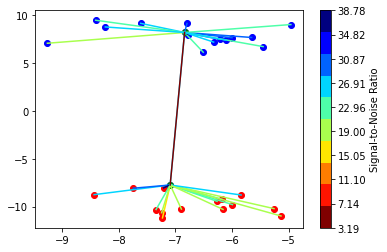

[{'Cluster Head': 'client21',
  'Members': ['client1',
   'client3',
   'client6',
   'client7',
   'client8',
   'client9',
   'client10',
   'client13',
   'client17',
   'client19',
   'client22',
   'client25',
   'client28',
   'client29',
   'client30'],
  'SNR': [['client21', 'client1', 24.379500056373146],
   ['client30', 'client2', 20.667552074605233],
   ['client21', 'client3', 20.687831438886228],
   ['client30', 'client4', 24.69239731815961],
   ['client30', 'client5', 22.618275146014412],
   ['client21', 'client6', 27.638643170215122],
   ['client21', 'client7', 20.58950357160844],
   ['client21', 'client8', 28.026867542208983],
   ['client21', 'client9', 27.488965946017608],
   ['client21', 'client10', 28.42787694769306],
   ['client30', 'client11', 20.522510276304864],
   ['client30', 'client12', 18.03829535579888],
   ['client21', 'client13', 21.476234892930496],
   ['client30', 'client14', 17.424868631219297],
   ['client30', 'client15', 28.165566535818176],
   ['clien

In [2]:
cluster_former()